In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 데이터 설명
* TurbID - 발전기 ID
* Day - 날짜
* Tmstamp - 시간
* Wspd - 풍속
* Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이
* Etmp - 외부 온도
* Itmp - 터빈 내부 온도
* Ndir - 터빈이 바라보는 방향 각도
* Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름
* Prtv - 무효전력 : 에너지원을 필요로  하지 않는 전력
* Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력 <br><br>

* <b>label: Patv </b>
# 결론적으로 134개 터빈의 201~202일, 즉 2일간의 Patv값을 예측해야 합니다.

# EDA
<font color=red>
1. Tmstamp를 hour과 minute로 변경 (minute 제거) <br>
2. 5가지 규칙에 해당하는 Patv = 0으로 변경 <br>
3. interpolate 후 bfill (Day 65~67구간 채워줌) <br>
⇒ Pab와 Patv의 관계에서는 Pab2, 3을 버려도 될듯함. <br>
4. Pab1, 2, 3을 비교해서 가장 큰 값을 Pab에다가 대입 (새로운 Pab 컬럼 설정) <br>

*주의사항: 일단 내부 및 온도 처리하지 않기.
    
</font>

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [5]:
train_data.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [6]:
train_data.tail(3)

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
3859197,134,200,23:30,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23:40,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15
3859199,134,200,23:50,4.79,-3.65,8.53,10.01,168.58,0.01,0.01,0.01,-119.76,264.17


In [7]:
# 결론적으로 134개 터빈의 201~202일, 즉 2일간의 Patv값을 예측해야 합니다.

In [8]:
sample_submission.head(3)

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,201,00:00,0,0,0,0,0,0,0,0,0,9999
1,1,1,201,00:10,0,0,0,0,0,0,0,0,0,9999
2,2,1,201,00:20,0,0,0,0,0,0,0,0,0,9999


In [9]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [10]:
# # method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# # 결측값 처리
# train_data = train_data.fillna(method = 'ffill').fillna(method='bfill')

# print(train_data.isnull().sum())

In [11]:
df_updated = train_data.copy()

In [12]:
df_updated

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,23:20,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,23:30,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23:40,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


In [13]:
df = df_updated[['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].copy()
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


# Timestamp 변환 (시간, 분)으로 변경
* hour, minute로 변환

In [14]:
df['Tmstamp'][0].split(':')

['00', '00']

In [15]:
a, b = df['Tmstamp'][20].split(':')
a, b

('03', '20')

In [16]:
print(int(a))

3


In [17]:
def make_hour(values):
    a, b = values.split(':')
    
    return int(a)

df['hour'] = df['Tmstamp'].apply(lambda x: make_hour(x))   

In [18]:
def make_minute(values):
    a, b = values.split(':')
    if b == '00':
        return 0
    elif b== '10':
        return 1
    elif b== '20':
        return 2
    elif b== '30':
        return 3
    elif b== '40':
        return 4
    elif b== '50':
        return 5

df['minute'] = df['Tmstamp'].apply(lambda x: make_minute(x))

In [19]:
df.drop(columns=['Tmstamp'], inplace=True)

In [20]:
df

,TurbID,Day,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,hour,minute
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,0,1
2,1,1,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,0,2
3,1,1,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,0,3
4,1,1,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,23,1
3859196,134,200,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60,23,2
3859197,134,200,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60,23,3
3859198,134,200,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,23,4


In [21]:
# 순서 넘겨주기.
df = df[['TurbID', 'Day', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

In [22]:
df.head()

,TurbID,Day,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,0,2,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,0,3,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,0,4,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


# 수치형 data간의 corr

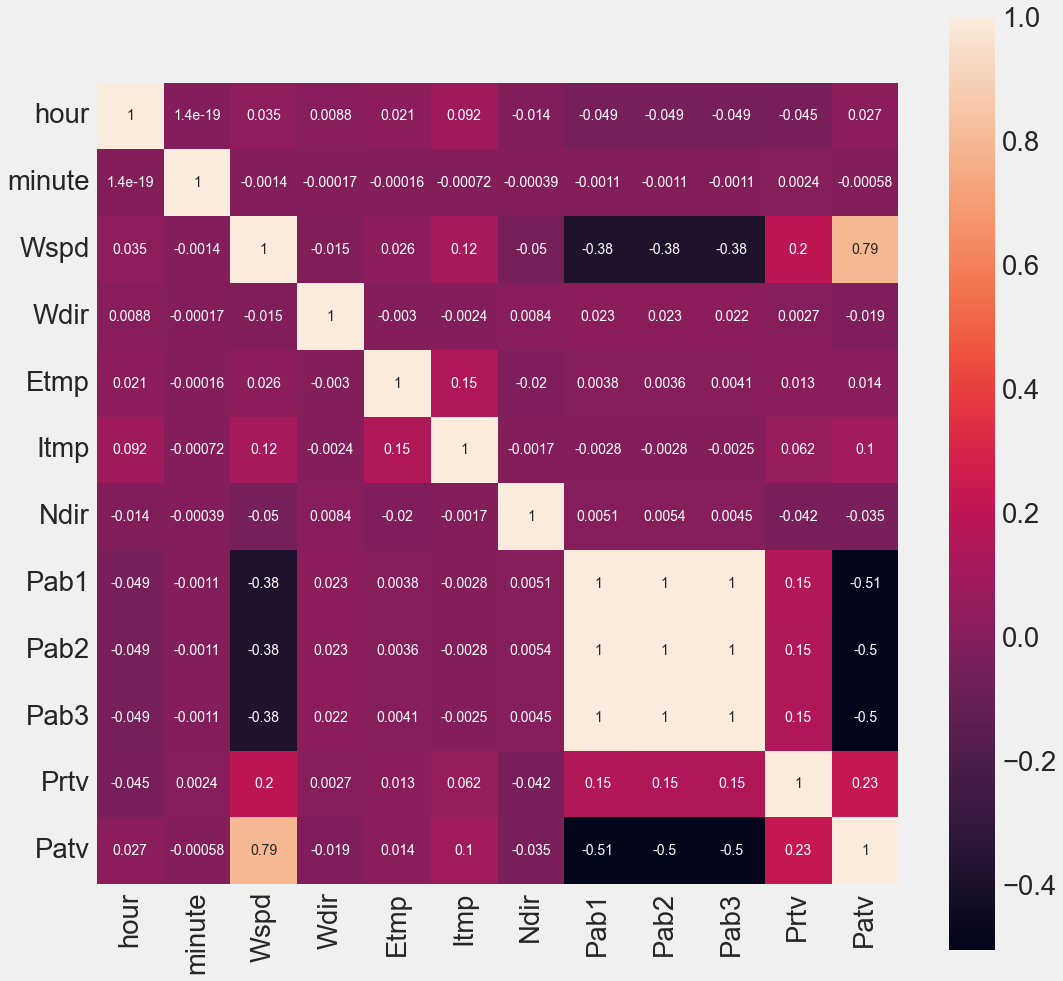

In [23]:
plt.subplots(figsize=(16, 16))
sns.heatmap(df[['hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].corr(), annot=True, square=True)
plt.show()

In [24]:
train_data = df.copy()
train_data

,TurbID,Day,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23,1,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65
3859196,134,200,23,2,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-93.64,221.60
3859197,134,200,23,3,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-111.20,220.60
3859198,134,200,23,4,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15


# 5가지 규칙에 해당하는 Patv 값 제거.

In [25]:
a = train_data[(train_data['Patv'] <=0) & (train_data['Wspd'] > 2.5)].index
train_data.loc[a, 'Patv'] = 0

a = train_data[train_data['Patv'].isnull()==True].index
train_data.loc[a, 'Patv'] = 0

a = train_data[(train_data['Pab1'] > 89) | (train_data['Pab2'] > 89) | (train_data['Pab3'] > 89)].index
train_data.loc[a, 'Patv'] = 0

a = train_data[(train_data['Ndir'] > 720) | (train_data['Ndir'] < -720)].index
train_data.loc[a, 'Patv'] = 0

a = train_data[(train_data['Wdir'] > 180) | (train_data['Wdir'] < -180)].index
train_data.loc[a, 'Patv'] = 0

# interpolate 후 bfill
* Day 65~67 구간 비어 있는 곳을 interpolate로 채워줌.

In [26]:
# bfill 해준 것. (Tmstamp = 0에다가)
train_data = train_data.interpolate(method='values')
train_data = train_data.fillna(method = 'bfill')

train_data.head()

,TurbID,Day,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,0.00
1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,0,2,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,0,3,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,0,4,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [27]:
train_data.isnull().sum()

TurbID    0
Day       0
hour      0
minute    0
Wspd      0
Wdir      0
Etmp      0
Itmp      0
Ndir      0
Pab1      0
Pab2      0
Pab3      0
Prtv      0
Patv      0
dtype: int64

# Pab 새로운 컬럼 설정.
* Pab1, 2, 3을 비교해서 가장 큰 값을 Pab에다가 대입

In [28]:
import math

def Make_Pab(Pab1, Pab2, Pab3):
    max_pab = max(Pab1, Pab2, Pab3)
    return max_pab
    
train_data['Pab'] = train_data.apply(lambda x: Make_Pab(x['Pab1'], x['Pab2'], x['Pab3']), axis=1) 

In [29]:
train_data.drop(columns= ['Pab1', 'Pab2', 'Pab3'], inplace=True)

In [30]:
train_data.head()

,TurbID,Day,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Prtv,Patv,Pab
0,1,1,0,0,6.17,-3.99,30.73,41.80,25.92,-0.25,0.00,1.0
1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,-0.25,494.66,1.0
2,1,1,0,2,6.27,-2.18,30.60,41.63,20.91,-0.24,509.76,1.0
3,1,1,0,3,6.42,-0.73,30.52,41.52,20.91,-0.26,542.53,1.0
4,1,1,0,4,6.25,0.89,30.49,41.38,20.91,-0.23,509.36,1.0


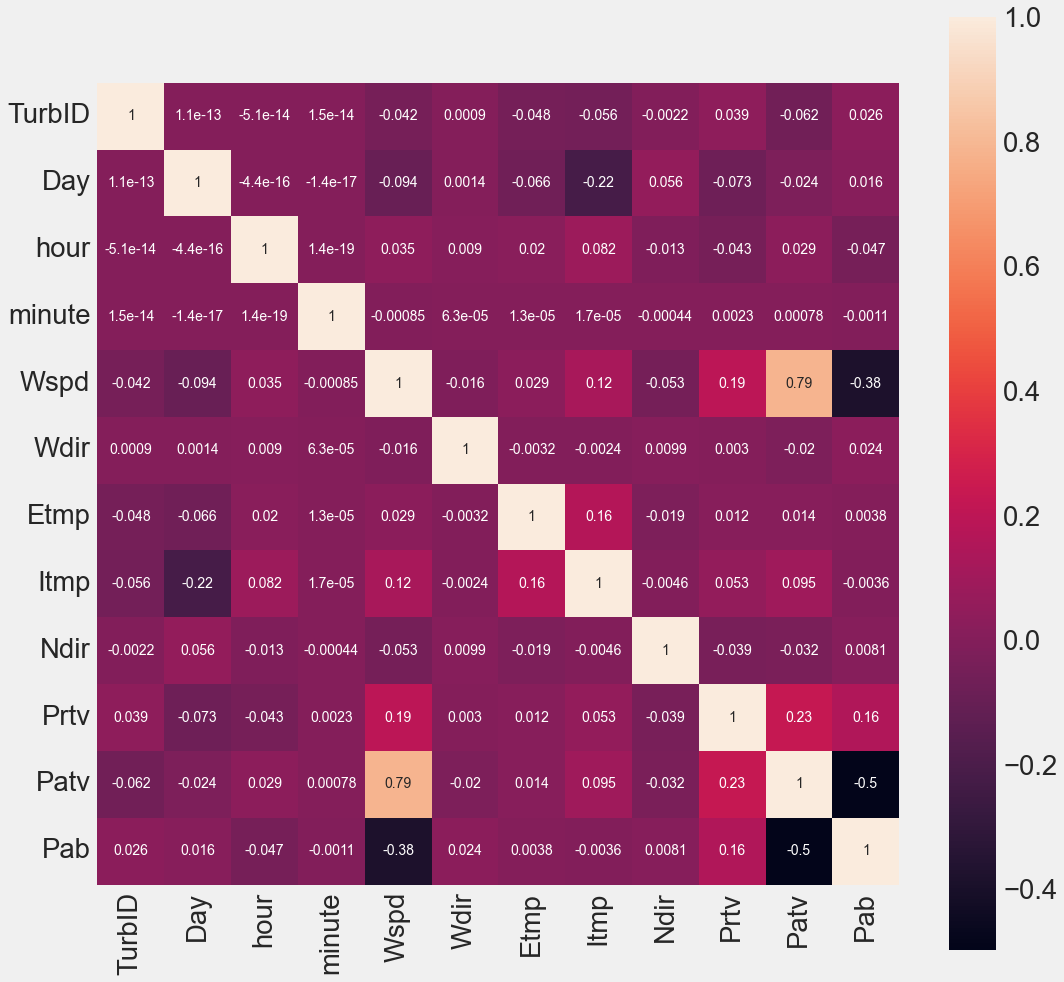

In [31]:
plt.subplots(figsize=(16, 16))
sns.heatmap(train_data.corr(), annot=True, square=True)
plt.show()

# 테스트
## Standard Scaer 넣기.

NameError: name 'ᄆᄂᄋᄅᄆᄂᄋᄅ' is not defined

In [ ]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# # 결측값 처리
# train_data = train_data.fillna(method = 'ffill').fillna(method='bfill')

# print(train_data.isnull().sum())

# 입력 값과 출력 값 데이터를 위한 코드
https://data-analysis-expertise.tistory.com/67

In [33]:
def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 201 - 6):
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Patv"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp.drop(["TurbID", "Day", "minute"], axis = 1)
           
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))   
    return train_x, train_y

In [34]:
train_x, train_y = make_train_data(train_data)

100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.28it/s]


In [35]:
len(train_x)

25996

In [36]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

#GPU 자원이 부족한 경우 아래 코드를 이용하세요
'''from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)'''

'from tensorflow.compat.v1 import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\n\nconfig = ConfigProto()\nconfig.gpu_options.allow_growth = True\nsession = InteractiveSession(config=config)'

In [37]:
train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y = np.array(train_y)

In [38]:
print(train_x.shape, train_y.shape)

(25996, 720, 9) (25996, 288)


In [39]:
train_x[0].shape[1]

9

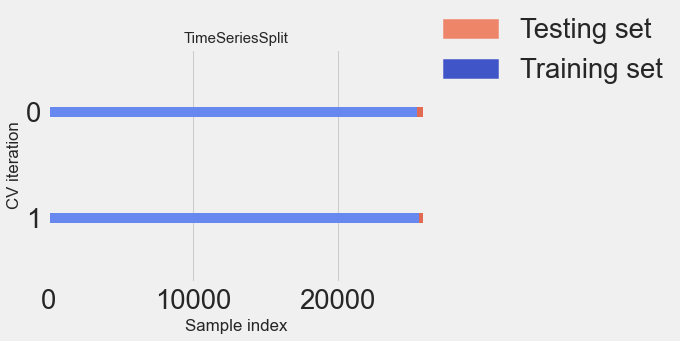

In [40]:
# 25996 = 터빈 X Day (test: 134*2 = 268)
XX = np.arange(25996)

n_split = 2

tscv = TimeSeriesSplit(n_splits=n_split, test_size=134)

plot_cv_indices(tscv, XX, n_splits=n_split)

In [41]:
for i, (train_index, test_index) in enumerate(tscv.split(train_x)):
    print("cv:", i+1, "TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]

cv: 1 TRAIN: [    0     1     2 ... 25725 25726 25727] TEST: [25728 25729 25730 25731 25732 25733 25734 25735 25736 25737 25738 25739
 25740 25741 25742 25743 25744 25745 25746 25747 25748 25749 25750 25751
 25752 25753 25754 25755 25756 25757 25758 25759 25760 25761 25762 25763
 25764 25765 25766 25767 25768 25769 25770 25771 25772 25773 25774 25775
 25776 25777 25778 25779 25780 25781 25782 25783 25784 25785 25786 25787
 25788 25789 25790 25791 25792 25793 25794 25795 25796 25797 25798 25799
 25800 25801 25802 25803 25804 25805 25806 25807 25808 25809 25810 25811
 25812 25813 25814 25815 25816 25817 25818 25819 25820 25821 25822 25823
 25824 25825 25826 25827 25828 25829 25830 25831 25832 25833 25834 25835
 25836 25837 25838 25839 25840 25841 25842 25843 25844 25845 25846 25847
 25848 25849 25850 25851 25852 25853 25854 25855 25856 25857 25858 25859
 25860 25861]
cv: 2 TRAIN: [    0     1     2 ... 25859 25860 25861] TEST: [25862 25863 25864 25865 25866 25867 25868 25869 25870 25871 

In [42]:
train_x[0].shape[0]

720

# 모델 학습
* 모델 저장과 복원: https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko
* 딥러닝 tensorflow에서 학습된 모델 저장 및 불러오기: https://minimin2.tistory.com/105


In [43]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM, BatchNormalization
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
import kerastuner as kt
import IPython

from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
import IPython


import matplotlib.pyplot as plt

In [44]:
train_x[0].shape[0], train_x[0].shape[1]

(720, 9)

# 하이퍼파라미터 튜닝 + 모델
학습과정 표시하기: https://tykimos.github.io/2017/07/09/Training_Monitoring/

In [45]:
import kerastuner
import numpy as np
from sklearn import model_selection

In [46]:
# class CVTuner(kerastuner.engine.tuner.Tuner):
#     # 간단한 Sequential 모델을 정의합니다
#     def create_model(hp):
#         model = Sequential()
    
#         hp_unit = hp.Int('units', min_value = 128, max_value = 1024, step = 32) # 128~1024
#         model.add(LSTM(units=hp_unit, input_shape=(train_x[0].shape[0], train_x[0].shape[1]))) # n X 720
#         model.add(tf.keras.layers.Reshape((-1, hp_unit)))
        
#         hp_unit = hp.Int('units', min_value = 128, max_value = 1024, step = 32) # 128~1024
#         model.add(LSTM(units=hp_unit, input_shape=(train_x[0].shape[0], train_x[0].shape[1]))) # n X 512
            
#         hp_unit = hp.Int('units', min_value = 128, max_value = 1024, step = 32) # 128~1024
#         model.add(Dense(units=hp_unit, activation='relu'))
#         model.add(Dense(288, activation='relu'))
#          # model.add(Activation("relu"))
            
#         hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
#         optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)       
            
            
#         model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
            
#         # model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
                    
#         return model


# # keras tuner api의 hypermodel 사용
# #  Keras 튜닝 방법 : RandomSearch, Hyperband, BaysesianOptimization, Sklearn
    
#     def run_trial(self, trial, x, y, batch_size=128, epochs=1):
#         n_split = 5
#         tscv = TimeSeriesSplit(n_splits=n_split, test_size=2596)
#         val_losses = []
        
#         for i, (train_index, test_index) in enumerate(tscv.split(train_x)):
#             print("cv:", i+1, "TRAIN:", train_index, "TEST:", test_index)
#             X_train, X_test = train_x[train_index], train_x[test_index]
#             y_train, y_test = train_y[train_index], train_y[test_index]
            
#             model = self.hypermodel.build(trial.hyperparameters)
#             model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
            
#             val_losses.append(model.evaluate(X_test, y_test))
#             self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
#             self.save_model(trial.trial_id, model)
            
        

In [47]:
# tuner = CVTuner(
#   hypermodel=create_model,
#   oracle=kerastuner.oracles.BayesianOptimization(
#     objective='val_loss',
#     max_trials=40))

In [48]:
# class ClearTrainingOutput(tf.keras.callbacks.Callback):
#     def on_train_end(*args, **kwargs):
#         IPython.display.clear_output(wait = True)

In [49]:
# tuner.search(train_x, train_y, batch_size=64, epochs=10)

In [50]:
# print(f"""
# 최적화된 첫 번째 Dense 노드 수 : {best_hp.get('units')} 
# 최적화된 2 번째 Dense 노드 수 : {best_hp.get('units1')} 
# 최적화된 3 번째 Dense 노드 수 : {best_hp.get('units2')} 
# 최적화된 4 번째 Dense 노드 수 : {best_hp.get('units3')} 
# 최적화된  learnig rate : {best_hp.get('learning_rate')} 입니다.
# """)

# 모델

In [51]:
# # 간단한 Sequential 모델을 정의합니다
# def create_model():
    
#     for i, (train_index, test_index) in enumerate(tscv.split(train_x)):
#         print("cv:", i+1, "TRAIN:", train_index, "TEST:", test_index)
#         X_train, X_test = train_x[train_index], train_x[test_index]
#         y_train, y_test = train_y[train_index], train_y[test_index]
        
#         model = Sequential()
        
#         model.add(LSTM(720, input_shape=(train_x[0].shape[0], train_x[0].shape[1]))) # n X 512
#         model.add(tf.keras.layers.Reshape((-1, 720)))
#         model.add(LSTM(512, input_shape=(train_x[0].shape[0], train_x[0].shape[1]))) # n X 512
#         model.add(Dense(516))
#         model.add(Activation("relu"))

#         model.add(Dense(288))
#         model.add(Activation("relu"))
    
#         optimizer = tf.optimizers.RMSprop(0.001)
        
#         model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
#         hist = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test))
        
#         # 5. 모델 학습 과정 표시하기
#         %matplotlib inline
#         import matplotlib.pyplot as plt
        
#         fig, loss_ax = plt.subplots(figsize=(20, 10))

#         acc_ax = loss_ax.twinx()

#         loss_ax.plot(hist.history['loss'], 'y', label='train loss(mse)')
#         loss_ax.plot(hist.history['val_loss'], 'r', label='val loss(mse)')
        
#         acc_ax.plot(hist.history['mae'], 'b', label='train mae')
#         acc_ax.plot(hist.history['val_mae'], 'g', label='val mae')
        
#         loss_ax.set_xlabel('epoch')
#         loss_ax.set_ylabel('loss')
#         acc_ax.set_ylabel('mae')
        
#         loss_ax.legend(loc='upper left')
#         acc_ax.legend(loc='lower left')
        
#         plt.show()
        
        
#     return model

In [52]:
# model = create_model()

In [53]:
# model.summary()

# 하이퍼 파라미터 튜닝

In [54]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

In [55]:
print(X_train.shape, y_train.shape)

(25862, 720, 9) (25862, 288)


In [56]:
print(X_test.shape, y_test.shape)

(134, 720, 9) (134, 288)


In [57]:
X_test[0]

array([[ 0.00000000e+00,  1.21300000e+01,  2.54000000e+00, ...,
         1.54980000e+02,  1.37838000e+03,  7.70000000e+00],
       [ 0.00000000e+00,  1.02800000e+01, -6.20000000e-01, ...,
         1.41560000e+02,  1.40090000e+03,  1.83000000e+00],
       [ 0.00000000e+00,  1.20700000e+01,  2.90000000e+00, ...,
         1.70340000e+02,  1.42214000e+03,  6.36000000e+00],
       ...,
       [ 2.30000000e+01,  3.80560311e+00,  2.41073930e+00, ...,
        -3.58249805e+01,  0.00000000e+00,  1.21400778e-02],
       [ 2.30000000e+01,  3.82338521e+00,  2.40898833e+00, ...,
        -3.59263424e+01,  0.00000000e+00,  1.23346304e-02],
       [ 2.30000000e+01,  3.84116732e+00,  2.40723735e+00, ...,
        -3.60277043e+01,  0.00000000e+00,  1.25291829e-02]])

In [ ]:
ㅁㄴㅇㄹㅁㄴㅇㄹ

In [58]:
# 간단한 Sequential 모델을 정의합니다
def create_model(hp):
    
    #NUM_LAYERS = Range('num_layers', 1, 3, 5, group='dense')
    
    
    model = Sequential()
    
    hp_unit = hp.Int('units1', min_value = 288, max_value = 1024, step = 32) # 128~1024
    model.add(LSTM(units=hp_unit, input_shape=(train_x[0].shape[0], train_x[0].shape[1])) ) # n X 720
    model.add(tf.keras.layers.Reshape((-1, hp_unit)))
    
    hp_unit = hp.Int('units2', min_value = 288, max_value = 1024, step = 32) # 128~1024
    model.add(LSTM(units=hp_unit, input_shape=(train_x[0].shape[0], train_x[0].shape[1]))) # n X 512
    
    hp_unit = hp.Int('dense_layer', min_value = 1, max_value = 5, step = 32) # 128~1024
    for _ in range(hp_unit):
        hp_unit = hp.Int('units3', min_value = 288, max_value = 1024, step = 32) # 128~1024
        model.add(Dense(units=hp_unit, activation='relu'))                
    model.add(Dense(288, activation='relu'))
     # model.add(Activation("relu"))
        
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)       
        
        
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        # model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))
                
    return model


# keras tuner api의 hypermodel 사용
#  Keras 튜닝 방법 : RandomSearch, Hyperband, BaysesianOptimization, Sklearn



In [59]:
# hyperband 튜너를 사용한 인스턴스화
tuner = kt.Hyperband(create_model,
                     objective = 'val_mae', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir_several_layers',
                     project_name = 'intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir_several_layers\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir_several_layers\intro_to_kt\tuner0.json


In [60]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [61]:
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [62]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp

In [63]:
print(f"""
최적화된 1 번째 Dense 노드 수 : {best_hp.get('units1')} 
최적화된 2 번째 Dense 노드 수 : {best_hp.get('units2')} 
최적화된 3 번째 Dense 노드 수 : {best_hp.get('units3')} 
최적화된 dense_layer 층 수 : {best_hp.get('dense_layer')} 
최적화된  learnig rate : {best_hp.get('learning_rate')} 입니다.
""")


최적화된 1 번째 Dense 노드 수 : 736 
최적화된 2 번째 Dense 노드 수 : 960 
최적화된 3 번째 Dense 노드 수 : 384 
최적화된 dense_layer 층 수 : 1 
최적화된  learnig rate : 0.001 입니다.



In [ ]:
sadfasdfs

In [66]:
# best 파라미터로 모델 형성
model = tuner.hypermodel.build(best_hp)
model.fit(X_train, y_train, epochs=10, validation_data = (X_test, y_test))

Epoch 1/10
809/809 [==============================] - 41s 47ms/step - loss: 170047.7031 - mae: 315.3119 - val_loss: 155057.0781 - val_mae: 305.7052
Epoch 2/10
809/809 [==============================] - 38s 47ms/step - loss: 150212.9375 - mae: 293.9017 - val_loss: 148423.8906 - val_mae: 277.7683
Epoch 3/10
809/809 [==============================] - 38s 47ms/step - loss: 136092.0781 - mae: 276.6015 - val_loss: 133194.6875 - val_mae: 263.3551
Epoch 4/10
809/809 [==============================] - 38s 47ms/step - loss: 122726.0781 - mae: 259.2822 - val_loss: 130740.3125 - val_mae: 248.4184
Epoch 5/10
809/809 [==============================] - 38s 47ms/step - loss: 108607.6875 - mae: 240.7507 - val_loss: 110000.2344 - val_mae: 240.2090
Epoch 6/10
809/809 [==============================] - 39s 48ms/step - loss: 94833.4375 - mae: 220.8999 - val_loss: 104448.2031 - val_mae: 225.6084
Epoch 7/10
809/809 [==============================] - 39s 48ms/step - loss: 84580.2656 - mae: 204.7344 - val_loss

In [ ]:
asdfasdfasdf

# 201일, 202일 Patv 추론

In [67]:
test_data_list = [x for x in range(196, 201)] # 196~200

test_data = train_data[train_data['Day'].isin(test_data_list)]

test_data = test_data.drop(["TurbID", "Day", "minute"], axis=1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])

In [68]:
test_data.shape

(134, 720, 9)

In [69]:
pred = model.predict(test_data)
pred = pred.reshape(-1)

In [70]:
pred

array([269.17184, 272.9556 , 221.74211, ..., 366.83203, 354.2571 ,
       343.86984], dtype=float32)

In [71]:
sample_submission['Patv'] = pred

sample_submission.to_csv('0710_Basemodel_LSTM_EDA_tscv_testsize_134.csv', index=False)